In [ ]:
# for colab
from google.colab import drive
drive.mount('/content/drive')
% cd drive/MyDrive/Plankton-Patrol/notebooks/plankton_patrol_models

# Introduction

This notebook is for practicing XGBoost and initial analyzation of Tidal Benthic dataset from the [Chesapeake Bay Project DataHub](https://datahub.chesapeakebay.net/LivingResources). This data goes through September 26, 2013.

The Tidal Benthic database measures sediment, bio mass data, taxonomic data, and water quality data. These separate datasets were merged using the monitoring event data, as decribed by the [2012 Users Guide to CBP Biological Monitoring Data](https://d18lev1ok5leia.cloudfront.net/chesapeakebay/documents/guide2012_final.pdf). More cleaning is described in the [cleaning notebook](../../notebooks/planton_patrol-APIs/plank_cleaningBenthic.ipynb)

In [228]:
import shap
import xgboost
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import json


And read in our parameter dictionary

In [118]:
# Import from JSON file
with open('../../data/plank_CBPparam_dict.json', 'r') as f:
    benthic_param_dict = json.load(f)


# Using the 'wide' dataset

The 'wide' dataset converts each parameter to a column, creating one row per `FieldActivityId`. That is, any data with the same location (including depth), data, time, and sample volume will be in the same row of the dataframe. There are 903 data points from July 29, 2004 throught September 26, 2013.

## Basic set up

In [207]:
import pandas as pd

benthic_data_wide = pd.read_csv('../../data/plank_ChesapeakeBayBenthic_clean_wide.csv')

Now, a few columns somehow PCT_PI_ABUND cleaning. Let's remove them again.

In [208]:
benthic_data_wide = benthic_data_wide.drop(columns=['EventId','SampleType','SampleReplicate']).reset_index(drop=True)

In [209]:
benthic_data_wide.shape

(903, 568)

We can also verify that there are 903 unique samples.

In [210]:
benthic_data_wide['FieldActivityId'].nunique()

903

Since `FieldActitivyId` is a unique numerical value for each sample, it might give false correlations. Let's remove it (others should probably be removed later).

In [211]:
benthic_data_wide = benthic_data_wide.drop(columns='FieldActivityId')

A lot of parameters are missing values, especially the taxonomic and sediment data. Let's remove columns missing more than half of the values.

In [212]:
threshold = 0.5

missing_percentage = benthic_data_wide.isnull().mean()

columns_to_keep = missing_percentage[missing_percentage <= threshold].index

# Create a new DataFrame with only the columns to keep
benthic_data_less_wide = benthic_data_wide[columns_to_keep]

print('Remaining columns:', benthic_data_less_wide.columns)


Remaining columns: Index(['CBSeg2003', 'CBSeg2003Description', 'Station', 'Latitude', 'Longitude',
       'TotalDepth', 'Source', 'ProjectIdentifier', 'SampleVolume', 'PDepth',
       'Salzone', 'MOIST', 'SAND', 'SILTCLAY', 'TC', 'TIC', 'TN', 'TOC',
       'PCT_CARN_OMN', 'PCT_DEPO', 'PCT_PI_ABUND', 'PCT_PI_BIO',
       'PCT_PS_ABUND', 'PCT_PS_BIO', 'SW', 'TOTAL_SCORE', 'TOT_ABUND',
       'TOT_BIOMASS_G', 'SampleDepth', 'DO', 'DO_SAT_P', 'PH', 'SALINITY',
       'SPCOND', 'WTEMP', 'SampleDateTime'],
      dtype='object')


## Updating the dictionary--first time only

Some of these columns are already in our parameter dictionary, and some do not need to be (SampleDate, Latitude, Longitude). Let's find which ones are missing.

In [ ]:
columns_in_data = benthic_data_less_wide.columns.to_list()

no_dict_columns = ['CBSeg2003', 'CBSeg2003Description', 'Station', 'Latitude', 'Longitude', 'SampleDate', 'SampleTime', 'TotalDepth', 'Source','ProjectIdentifier', 'SampleVolume', 'PDepth', 'Salzone']

columns_to_check = [value for value in columns_in_data if value not in no_dict_columns]

[col for col in columns_to_check if col not in benthic_param_dict]


Now we consult the [ 2012 Users Guide to CBP Biological Monitoring Data](https://d18lev1ok5leia.cloudfront.net/chesapeakebay/documents/guide2012_final.pdf)

In [ ]:
additional_param_dict = {'PCT_CARN_OMN': {'Units': 'Percent', 'Type':'Percent Carnivores And Omnivores'},
 'PCT_DEPO': {'Units': 'Percent', 'Type':'Percent Deep Deposit Feeders'},
 'PCT_PI_ABUND': {'Units': 'Percent', 'Type': 'Percent Pollution Indicative Species Abundance'},
 'PCT_PI_BIO': {'Units': 'Percent', 'Type': 'Percent Pollution Indicative Species Biomass'},
 'PCT_PS_ABUND': {'Units': 'Percent', 'Type': 'Percent Pollution Sensitive Species Abundance-Tidal Benthic'},
 'PCT_PS_BIO': {'Units': 'Percent', 'Type': 'Percent Pollution Sensitive Species Biomass'},
 'SW': {'Units': 'None', 'Type': 'Shannon Wiener Index'},
 'TOTAL_SCORE': {'Units': 'None', 'Type': 'Total Benthic Restoration Goal Score For Sample'},
 'TOT_ABUND': {'Units': 'Count', 'Type': 'Total Number Of Individuals'},
 'TOT_BIOMASS_G': {'Units': 'Will vary', 'Type': 'Total Species Biomass In'},
 'SampleDepth':  {'Units': 'M', 'Type': 'Sample Collection DepthTotal Species Biomass In'}}

In [ ]:
# # only run once!
# new_param_dict = {**benthic_param_dict, **additional_param_dict}

# with open('../../data/plank_CBPparam_dict.json', 'w') as f:
#     json.dump(new_param_dict, f)

# # Reimport from JSON file
# with open('../../data/plank_CBPparam_dict.json', 'r') as f:
#     benthic_param_dict = json.load(f)

## XGBoost

Since this dataset did not include any chlrophyl data, we will pick some other parameters to model. How about `PCT_PI_BIO` - Percent Pollution Indicative Species.

### Preprocess

In [218]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import numpy as np

import xgboost as xgb

Converting `SampleDateTime` to an integer. First converting back to datetime.

In [219]:
benthic_clean = benthic_data_less_wide.copy()

benthic_clean['SampleDateTime'] = pd.to_datetime(benthic_data_less_wide['SampleDateTime'], format='%Y-%m-%d %H:%M:%S')

benthic_clean['IntDateTime'] = benthic_clean['SampleDateTime'].astype('int64')//10**9

benthic_clean['floatDateTime'] = benthic_clean['IntDateTime'].astype('float64')


benthic_clean = benthic_clean.drop(columns=['SampleDateTime','IntDateTime'])

Modifying Pushkar's function for converting datatypes, we make sure every column is either a float or category.

In [220]:
numerical_features = benthic_clean.select_dtypes(include='float').columns
categorical_features = list(set(benthic_clean.columns) - set(numerical_features))

In [221]:
def convert_dtypes(df):
    for col in df.columns:
        df[col] = df[col].replace("nan", np.nan)
        # print(df[col][564463])
        print(f"converting column {col}",end="\t")
        print(df[col].dtype)

        if col not in (numerical_features):
            df[col] = pd.Categorical(df[col])
            print("Categorical")
        elif col in numerical_features:
            # Try converting to numeric (float)
            df[col] = pd.to_numeric(df[col], errors="coerce")

            # Handle missing values
            df[col].fillna(df[col].median(), inplace=True)
            print("Numeric")
        else:
            print(f"{col}: string")
            df[col] = df[col].astype(str)
            print("string")
        print(df[col].dtype)
    return df

In [222]:
benthic_clean = convert_dtypes(benthic_clean)

converting column CBSeg2003	object
Categorical
category
converting column CBSeg2003Description	object
Categorical
category
converting column Station	object
Categorical
category
converting column Latitude	float64
Numeric
float64
converting column Longitude	float64
Numeric
float64
converting column TotalDepth	float64
Numeric
float64
converting column Source	object
Categorical
category
converting column ProjectIdentifier	object
Categorical
category
converting column SampleVolume	float64
Numeric
float64
converting column PDepth	float64
Numeric
float64
converting column Salzone	object
Categorical
category
converting column MOIST	float64
Numeric
float64
converting column SAND	float64
Numeric
float64
converting column SILTCLAY	float64
Numeric
float64
converting column TC	float64
Numeric
float64
converting column TIC	float64
Numeric
float64
converting column TN	float64
Numeric
float64
converting column TOC	float64
Numeric
float64
converting column PCT_CARN_OMN	float64
Numeric
float64
convertin

/var/folders/rl/kqt6tbv90l9_pwc4927vdb340000gn/T/ipykernel_48711/514992669.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/var/folders/rl/kqt6tbv90l9_pwc4927vdb340000gn/T/ipykernel_48711/514992669.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

Let's check

In [223]:
benthic_clean.dtypes

CBSeg2003               category
CBSeg2003Description    category
Station                 category
Latitude                 float64
Longitude                float64
TotalDepth               float64
Source                  category
ProjectIdentifier       category
SampleVolume             float64
PDepth                   float64
Salzone                 category
MOIST                    float64
SAND                     float64
SILTCLAY                 float64
TC                       float64
TIC                      float64
TN                       float64
TOC                      float64
PCT_CARN_OMN             float64
PCT_DEPO                 float64
PCT_PI_ABUND             float64
PCT_PI_BIO               float64
PCT_PS_ABUND             float64
PCT_PS_BIO               float64
SW                       float64
TOTAL_SCORE              float64
TOT_ABUND                float64
TOT_BIOMASS_G            float64
SampleDepth              float64
DO                       float64
DO_SAT_P  

### Define and train regression


In [229]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def split_data(benthic_data_less_wide):
  # Split features and target
  X = benthic_clean.drop('PCT_PI_ABUND', axis=1)
  y = benthic_clean['PCT_PI_ABUND']

  for col in X.select_dtypes(include=['category']).columns:
    X[col] = X[col].cat.codes

  print(X.shape, y.shape)
   
  # Split into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

# Split the data
X_train, X_test, y_train, y_test = split_data(benthic_clean)

(903, 35) (903,)


In [230]:
params = dict()
params["tree_method"] = "hist"

In [231]:
model = xgb.XGBRegressor(enable_categorical=True)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [232]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE: %f" % (mse))

MSE: 83.058780


## Estimate the Shapley values

Copied from Pushkar

In [ ]:


explainer = shap.Explainer(model=model, masker=X_train)
explainer.__class__

# explainer = shap.TreeExplainer(model, data=cp.asarray(X_train_cp))
# shap_values = explainer.shap_values(cp.asarray(X_test_cp))

# Convert Shapley values back to NumPy arrays for compatibility
# shap_values = cp.asnumpy(shap_values)

shap.explainers._tree.TreeExplainer

In [ ]:
shap_values = explainer(X_test)

100%|===================| 430411/430475 [33:21<00:00]        

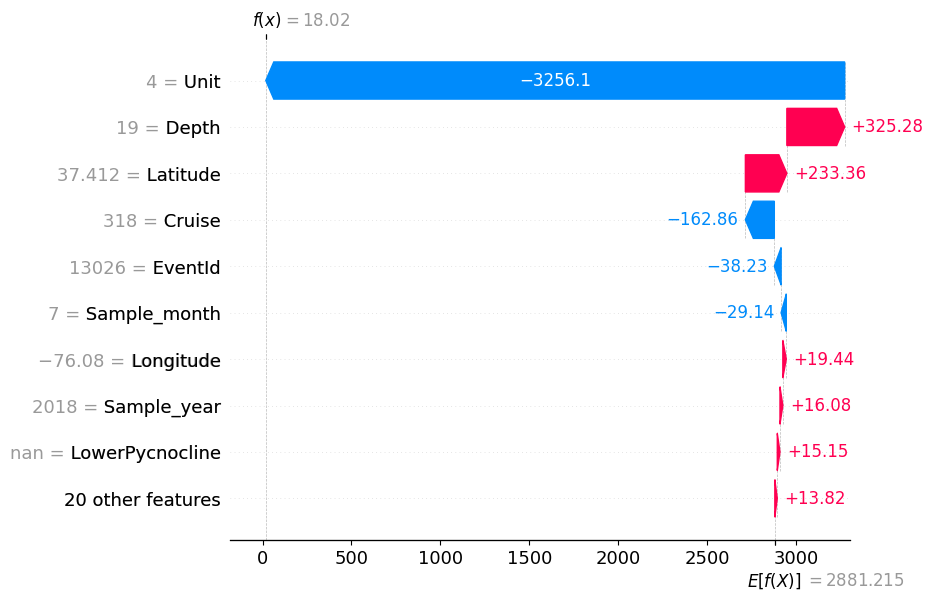

In [ ]:
shap.plots.waterfall(shap_values[0])